In [5]:
import numpy as np
from collections import deque
import rloutrading as rlou
from importlib import reload

In [6]:
# To-do: add softmax output

In [7]:
def relu(x):
    return np.maximum(0, x)

In [8]:
n_actions = 11

In [9]:
W1 = np.random.randn(4, 64)
W2 = np.random.randn(64, 64)
W3 = np.random.randn(64, 1)

In [10]:
# t, q, x, a
X = np.random.randn(2, 4)
nn_output = relu(relu(X @ W1) @ W2) @ W3
# nn_output = np.exp(nn_output) / np.exp(nn_output).sum()

In [11]:
nn_output

array([[-33.42024432],
       [-37.69515725]])

## Multidimensional "pseudo" DQN

In [12]:
W1 = np.random.randn(3, 64)
W2 = np.random.randn(64, 64)
W3 = np.random.randn(64, n_actions)

In [13]:
# t, q, x, a
a = [5, 0]
X = np.random.randn(2, 3)
nn_output = relu(relu(X @ W1) @ W2) @ W3
# nn_output = np.exp(nn_output) / np.exp(nn_output).sum()
nn_output[:, a]

array([[122.81682608, -52.54797939],
       [ 63.2333288 ,  30.92966615]])

In [14]:
def dqn_architecture(X, W):
    pass

In [15]:
replay_buffer = deque(maxlen=3)

In [16]:
actions = [0, 1, 1, 2, 3, 1, 0, 0, 1, 2, 1]
actions[3]

2

In [17]:
replay_buffer.append(actions[0])
replay_buffer

deque([0])

In [18]:
replay_buffer.append(actions[1])
replay_buffer

deque([0, 1])

In [19]:
# start training
replay_buffer.append(actions[2])
replay_buffer

deque([0, 1, 1])

In [20]:
replay_buffer.append(actions[3])
replay_buffer

deque([1, 1, 2])

In [21]:
architecture = [4, 64, 64, 1]

In [22]:
from numpy.random import randn

In [23]:
weights = [randn(i, j) for i,j in zip(architecture[:-1], architecture[1:])]

In [439]:
params ={'kappa': 5.0,
 'sigma': 1.2,
 'xbar': 100.0,
 'phi': 0.01,
 'gamma': 0.999,
 'c': 2.0,
 'T': 3.0,
 'dt': 0.1,
 'C': 200000.0,
 'D': 200000.0,
 "n_batches": 10,
  #"config": [4, 64, 64, 1],
   "config": 64,
   "buffer_size": 30}

In [440]:
reload(rlou)
dqntr = rlou.DQNTrading(**params, inventory_min=-4, inventory_max=4,
                        buy_max=2,buy_min=-2,n_price=40)

In [429]:
dqntr.run_episode(0)

In [414]:
%load_ext line_profiler

In [420]:
%lprun -f dqntr.learn_step -f dqntr.step_in_episode dqntr.q_learn(2, random_shock=True)

100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


In [441]:
dqntr.q_learn(50, random_shock=True)

100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


In [433]:
import matplotlib.pyplot as plt

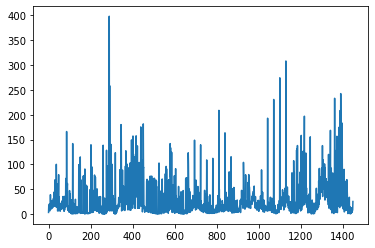

In [442]:
plt.plot(dqntr.error_history)

In [26]:
def Q(t, q, x, a):
    input_value = np.array([t, q, x, a])
    return input_value

In [27]:
n_layers = len(dqntr.weights)
t, q, x, a =  0, 0, 100.5, 3
input_value = np.array([t, q, x, a])

x_out = input_value[None, :]
for l, Wl in enumerate(dqntr.weights):
    x_out = x_out @ Wl
    if l != n_layers - 1:
        x_out = relu(x_out)
    
x_out

array([[2699.72648865]])

In [133]:
Xt = dqntr.simulate_ou_process(nsims=1)

In [214]:
class FFNet(nn.Module):
    def __init__(self, config):
        super(FFNet, self).__init__()
        self.config = config
        self.n_layers = len(config) - 1
        self.layers = self._initialize_layers()
        self.parameters = nn.ParameterList([layer for layer in self.layers])
        self.relu = nn.ReLU()
        
    def _initialize_layers(self):
        config_zip = zip(self.config[:-1], self.config[1:])
        layers = [nn.Linear(i, j) for i,j in config_zip]
        return layers

    def forward(self, x):
        h = x
        for l, Wl in enumerate(self.layers[:-1]):
            h = self.relu(Wl(h))
        y = self.layers[-1](h)
        
        return y

In [387]:
class FFNet(nn.Module):
    def __init__(self, n ):
        super(FFNet, self).__init__()
        
        # 2 input layer (t,S), 1 output channel, 2 hidden layers with n units each
        self.layer1 = nn.Linear(4, n)
        self.layer2 = nn.Linear(n, n)
        self.layer3 = nn.Linear(n, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.layer1(x))
        h2 = self.relu(self.layer2(h1))
        y = self.layer3(h2)
        
        return y

In [388]:
net = FFNet(64)
net.forward(torch.randn(5, 4))

tensor([[-0.0937],
        [ 0.0970],
        [-0.0678],
        [ 0.0736],
        [ 0.1635]], grad_fn=<AddmmBackward>)

In [392]:
X_in = torch.randn(5,4)

In [393]:
net(X_in)

tensor([[-0.0656],
        [ 0.1075],
        [ 0.0441],
        [ 0.1495],
        [ 0.1653]], grad_fn=<AddmmBackward>)

In [394]:
net.forward(X_in)

tensor([[-0.0656],
        [ 0.1075],
        [ 0.0441],
        [ 0.1495],
        [ 0.1653]], grad_fn=<AddmmBackward>)

In [300]:
X_in = np.random.randn(5, 4)
net.forward(torch.tensor(X_in).float())

tensor([[0.0757],
        [0.0795],
        [0.0973],
        [0.1339],
        [0.0288]], grad_fn=<AddmmBackward>)

In [244]:
class MyNet(nn.Module):

    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 2 input layer (t,S), 1 output channel, 2 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 1)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = nn.ReLU()(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)
        
        return y

In [291]:
net = MyNet(80)

In [292]:
buffer_size = 3
replay_buffer = deque(maxlen=buffer_size)

In [257]:
stage = (0.1, 10, 100.2), 2, 0.5, (0.2, 12, 100.3)
replay_buffer.append(stage)

In [258]:
replay_buffer

deque([((0.1, 10, 100.2), 2, 0.5, (0.2, 12, 100.3)),
       ((0.1, 10, 100.2), 2, 0.5, (0.2, 12, 100.3))])